# Generating names with recurrent neural networks


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")

TensorFlow 1.x selected.


# Load data

In [2]:
start_token = "^"  # so that the network knows that we're generating a first token
pad_token = "#"
with open("/content/Final.txt") as f:
  names = f.read().split('\n')
  names = [start_token + name.split('\t')[0] for name in names]

In [3]:
def clean(names):
  new_names=[]
  for i in names:
    if len(i)<3:
      continue
    elif i[1:].isnumeric():
      continue  
    elif len(i)>10:
      continue
    new_names.append(i.lower())   
  return new_names 
names = clean(names)     

In [4]:
print('number of samples:', len(names))
for x in names[:2]:
    print(x)

number of samples: 1707
^aida
^aida


max length: 10


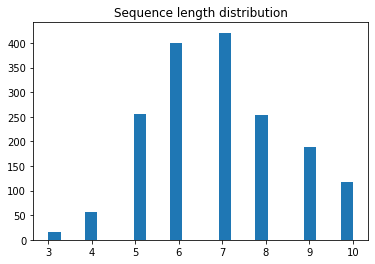

In [5]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [6]:
x=set()
tokens = [([x.add(j) for j in i]) for i in names]
x.add(pad_token)
tokens=x
tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

n_tokens: 51


In [7]:
token_to_id = dict(zip(tokens, np.arange(0,len(tokens))))

## `` to_matrix``
 takes in names and returns an array of shape (len(names), max_len) i.e each character in a individual name has been converted to a number and length of each word is made same by adding the id of '#' to the ends

In [8]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros( [len(names), max_len], dtype) + pad
    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix
    return names_ix

In [9]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

^aida
[[ 3 36 41 10 36]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

### Creating Cell Structure
* ``embed_x``: This basically will convert an index of a char to 16 dimension embedding. 
* ``get_h_next`` : this will take in an input of size embedding_size and a hidden layer from previous timestep and result in a new hidden layer
* ``get_probas`` : This will take in will take in the above and result in output of size num_tokens and correspond to the probability distribution of characters

In [10]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

embed_x = Embedding(n_tokens, embedding_size)

get_h_next = Dense(rnn_num_units, activation='relu')

get_probas = Dense(n_tokens, activation='softmax') 

Using TensorFlow backend.


We will generate names character by character starting with `start_token`:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week5/char-nn.png?raw=1" width=600>

### ``rnn_one_step``
* This defines one step of rnn
* It takes as input ```x_t and h_t```.
* ```x_t``` are characters taken from a batch of words at time step t
* ``x_t`` is converted to it's 16 dimension embedding ``x_t_emb`` of shape(?,16).
* Now



In [11]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    """
    # convert character id into embedding
    #print(h_t.shape)
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    # concatenate x_t embedding and previous h_t state
    x_and_h = keras.layers.Concatenate()([x_t_emb,h_t])
    #print(x_and_h.shape)
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

# RNN: loop

* ``input_sequence`` is of size ```(None, MAX_LENGTH)``` where MAX_LENGTH is the length of each word. 
* We iterate through each timestep total of MAX_LENGTH times and each time slice is send to rnn cell, and the resultant probablility distribution over ```n_tokens``` is appended into ``predicted_probas`` with each element of list being of shape ``(?,56)``.
* We modify it and finally get output for every input(except last) and get of shape ``(?,16-1,56)``

In [12]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)

# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]
print(predicted_probas.shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 9, 51)


# RNN: loss and gradients
* ``answers_matrix`` is formed by taking all the characters(their index) of all the words in a batch and flatten them to a vector. Then converting to a one hot encoding

In [13]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [14]:
loss = tf.reduce_mean(keras.losses.categorical_crossentropy(answers_matrix,predictions_matrix))
optimize = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# RNN: training

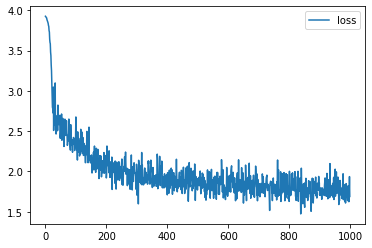

In [31]:
s = tf.compat.v1.Session()
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

# RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [32]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32)) 
next_probs, next_h = rnn_one_step(x_t, h_t)

In [33]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [38]:
# without prefix
for _ in range(1000):
  file1 = open("/content/untitled.txt","a")#append mode 
  stri = generate_sample()
  file1.write(stri+'\n') 
  file1.close() 

[link text](https://)

In [ ]:
for _ in range(10):
    print(generate_sample('na'))

nakten
naèchi
nalesshich
narichi
nawegbe
nagusuer
nanuro
nachicnai
na
nakebo
